# Machine Learning Basics
In this tutorial we learn how to split data, transform data and apply regularization using logistic regression example.

# Import Packages

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

In [91]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

**Download the data if needed (and unpack it into the Data folder), we use the same dataset as in the python intro:** <a href="https://www2.karlin.mff.cuni.cz/~kozmikk/files/data_devsample.zip" target="_blank">credit risk data</a> 

# Load Data
- Data sample represents data used in financial institutions for development of credit risk scoring models.
- This data sample was used in Kaggle competition arranged by Home Credit Group in 2018.
- Data includes binary target variable `TARGET` and multiple regressors to be used in model.
- Column `SK_ID_CURR` is used as unique identifier of credit application and columns `TIME` represents time of the application.
- Model should predict solvency of applicants at the time of application for credit.

In [92]:
# Load data - set index column, decimal point, separator
data = pd.read_csv('data_devsample.csv', sep = ',', decimal = '.', index_col = 'SK_ID_CURR')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2022-03-13 17:11:55


In [93]:
data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MIN_AMTCR_0M_INFM,MAX_AMTCR_0M_INFM,MEAN_AMTCR_0M_INFM,MEDIAN_AMTCR_0M_INFM,STD_AMTCR_0M_INFM,MIN_AMTCR_0M_6M,MAX_AMTCR_0M_6M,MEAN_AMTCR_0M_6M,MEDIAN_AMTCR_0M_6M,STD_AMTCR_0M_6M,MIN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MAX_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MEDIAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,STD_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MIN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MAX_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MEAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MEDIAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,STD_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MIN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MAX_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MEAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MEDIAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,STD_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MIN_AMTCR_0M_6M_TYPE_EQ_CLOSED,MAX_AMTCR_0M_6M_TYPE_EQ_CLOSED,MEAN_AMTCR_0M_6M_TYPE_EQ_CLOSED,MEDIAN_AMTCR_0M_6M_TYPE_EQ_CLOSED,STD_AMTCR_0M_6M_TYPE_EQ_CLOSED,MIN_DPD_0M_INFM,MAX_DPD_0M_INFM,MEAN_DPD_0M_INFM,MEDIAN_DPD_0M_INFM,STD_DPD_0M_INFM,MIN_DPD_0M_6M,MAX_DPD_0M_6M,MEAN_DPD_0M_6M,MEDIAN_DPD_0M_6M,STD_DPD_0M_6M,MIN_DPD_0M_INFM_TYPE_EQ_ACTIVE,MAX_DPD_0M_INFM_TYPE_EQ_ACTIVE,MEAN_DPD_0M_INFM_TYPE_EQ_ACTIVE,MEDIAN_DPD_0M_INFM_TYPE_EQ_ACTIVE,STD_DPD_0M_INFM_TYPE_EQ_ACTIVE,MIN_DPD_0M_6M_TYPE_EQ_ACTIVE,MAX_DPD_0M_6M_TYPE_EQ_ACTIVE,MEAN_DPD_0M_6M_TYPE_EQ_ACTIVE,MEDIAN_DPD_0M_6M_TYPE_EQ_ACTIVE,STD_DPD_0M_6M_TYPE_EQ_ACTIVE,MIN_DPD_0M_INFM_TYPE_EQ_CLOSED,MAX_DPD_0M_INFM_TYPE_EQ_CLOSED,MEAN_DPD_0M_INFM_TYPE_EQ_CLOSED,MEDIAN_DPD_0M_INFM_TYPE_EQ_CLOSED,STD_DPD_0M_INFM_TYPE_EQ_CLOSED,MIN_DPD_0M_6M_TYPE_EQ_CLOSED,MAX_DPD_0M_6M_TYPE_EQ_CLOSED,MEAN_DPD_0M_6M_TYPE_EQ_CLOSED,MEDIAN_DPD_0M_6M_TYPE_EQ_CLOSED,STD_DPD_0M_6M_TYPE_EQ_CLOSED,MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M,MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE,MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED,MEAN_AMTCR_OVERDUE_0M_IN

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 215138 to 259380
Columns: 196 entries, TARGET to MONTH
dtypes: float64(139), int64(40), object(17)
memory usage: 120.2+ MB


In [95]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   80 000
Number of unique indexes:   80 000
Number of columns:   196


## Metadata Definitions

In [96]:
# check values in column TARGET
data.TARGET.value_counts(dropna=False)

0.0    73584
1.0     6416
Name: TARGET, dtype: int64

In [97]:
#name of the target column
col_target = "TARGET"
#name of the time column
col_time = "TIME"

#name of the month column
col_month = "MONTH"
# #name of the day column
# col_day = "DAY"

In [98]:
# define list of predictors
cols_pred = list(data.columns[1:-4])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
CNT_CHILDREN                                                                       float64
AMT_INCOME_TOTAL                                                                   float64
AMT_CREDIT                                                                         float64
AMT_ANNUITY                                                                        float64
AMT_GOODS_PRICE                                                                    float64
REGION_POPULATION_RELATIVE                                                         float64
DAYS_BIRTH                                                                         float64
DAYS_EMPLOYED                                                                        int64
DAYS_REGISTRATION                                                                  float64
DAYS_ID_PUBLISH                                                                      int64
OWN_CAR_AGE                                   

## Data Exploration

In [99]:
description = data.describe(include='all').transpose()
pd.options.display.max_rows = 1000
display(description)
pd.options.display.max_rows = 200

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TARGET,80000,NaN,NaN,NaN,0.0802,0.271604,0,0,0,0,1
NAME_CONTRACT_TYPE,80000,2,Cash loans,72366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,80000,3,F,52488,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,80000,2,N,52682,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,80000,2,Y,55485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,55035,NaN,NaN,NaN,0.324648,0.637932,0,0,0,0,12
AMT_INCOME_TOTAL,80000,NaN,NaN,NaN,168266,109278,26100,112500,148500,202500,1.35e+07
AMT_CREDIT,80000,NaN,NaN,NaN,598242,400205,45000,270000,513531,808650,4.05e+06
AMT_ANNUITY,79994,NaN,NaN,NaN,27115.3,14471.5,1980,16573.5,24939,34644.4,225000
AMT_GOODS_PRICE,79937,NaN,NaN,NaN,537606,367401,40500,238500,450000,679500,4.05e+06


In [100]:
# define function that plots default rate in time
def default_rate_in_time(dt, col_month, col_target, yright_lim = None):
    dt_grp = dt.groupby(col_month).agg(
        tot_cnt = (col_target, len),
        default_rate = (col_target, np.mean)
    )
    
    ax1 = plt.subplot(111)
    ax1.bar(range(len(dt_grp)), dt_grp['tot_cnt'])
    ax1.set_xticks(range(len(dt_grp)))
    ax1.set_xticklabels(dt_grp.index, rotation = 90)
    ax1.set_xlabel('month')
    ax1.set_ylabel('count', loc='top')
    ax1.spines['right'].set_color('gray')
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.tick_params(axis='y', colors='gray')
    ax1.tick_params(axis='x', colors='gray')    
    
    ax2 = ax1.twinx()
    ax2.plot(range(len(dt_grp)), dt_grp['default_rate'], marker ='o', color = 'red')
    ax2.set_ylabel('default rate', loc='top', color='red')
    if yright_lim is not None:
        ax2.set_ylim(yright_lim)
    ax2.spines['right'].set_color('gray')
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_color('gray')
    ax2.spines['bottom'].set_color('gray')
    ax2.tick_params(axis='y', colors='gray')
    ax2.tick_params(axis='x', colors='gray')
    
    plt.show()

In [101]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MIN_AMTCR_0M_INFM,MAX_AMTCR_0M_INFM,MEAN_AMTCR_0M_INFM,MEDIAN_AMTCR_0M_INFM,STD_AMTCR_0M_INFM,MIN_AMTCR_0M_6M,MAX_AMTCR_0M_6M,MEAN_AMTCR_0M_6M,MEDIAN_AMTCR_0M_6M,STD_AMTCR_0M_6M,MIN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MAX_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MEDIAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,STD_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MIN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MAX_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MEAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MEDIAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,STD_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MIN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MAX_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MEAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MEDIAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,STD_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MIN_AMTCR_0M_6M_TYPE_EQ_CLOSED,MAX_AMTCR_0M_6M_TYPE_EQ_CLOSED,MEAN_AMTCR_0M_6M_TYPE_EQ_CLOSED,MEDIAN_AMTCR_0M_6M_TYPE_EQ_CLOSED,STD_AMTCR_0M_6M_TYPE_EQ_CLOSED,MIN_DPD_0M_INFM,MAX_DPD_0M_INFM,MEAN_DPD_0M_INFM,MEDIAN_DPD_0M_INFM,STD_DPD_0M_INFM,MIN_DPD_0M_6M,MAX_DPD_0M_6M,MEAN_DPD_0M_6M,MEDIAN_DPD_0M_6M,STD_DPD_0M_6M,MIN_DPD_0M_INFM_TYPE_EQ_ACTIVE,MAX_DPD_0M_INFM_TYPE_EQ_ACTIVE,MEAN_DPD_0M_INFM_TYPE_EQ_ACTIVE,MEDIAN_DPD_0M_INFM_TYPE_EQ_ACTIVE,STD_DPD_0M_INFM_TYPE_EQ_ACTIVE,MIN_DPD_0M_6M_TYPE_EQ_ACTIVE,MAX_DPD_0M_6M_TYPE_EQ_ACTIVE,MEAN_DPD_0M_6M_TYPE_EQ_ACTIVE,MEDIAN_DPD_0M_6M_TYPE_EQ_ACTIVE,STD_DPD_0M_6M_TYPE_EQ_ACTIVE,MIN_DPD_0M_INFM_TYPE_EQ_CLOSED,MAX_DPD_0M_INFM_TYPE_EQ_CLOSED,MEAN_DPD_0M_INFM_TYPE_EQ_CLOSED,MEDIAN_DPD_0M_INFM_TYPE_EQ_CLOSED,STD_DPD_0M_INFM_TYPE_EQ_CLOSED,MIN_DPD_0M_6M_TYPE_EQ_CLOSED,MAX_DPD_0M_6M_TYPE_EQ_CLOSED,MEAN_DPD_0M_6M_TYPE_EQ_CLOSED,MEDIAN_DPD_0M_6M_TYPE_EQ_CLOSED,STD_DPD_0M_6M_TYPE_EQ_CLOSED,MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M,MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE,MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED,MEAN_AMTCR_OVERDUE_0M_IN

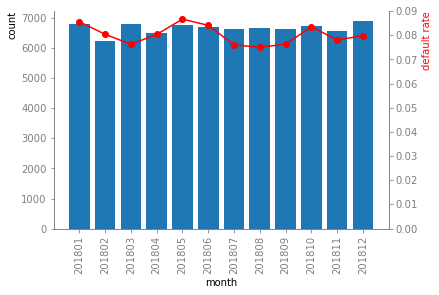

In [102]:
default_rate_in_time(data, col_month, col_target, yright_lim = [0, 0.09])

In [103]:
# define function that plots share of null values in time for given predictor
def share_of_nulls(dt, col_month, predictor):
    dt2 = dt[[col_month, predictor]]
    
    dt2 = dt2.assign(is_null=dt2[predictor].isnull().astype(int).values)
    dt_grp = dt2.groupby(col_month).agg(
        share_of_nulls = ('is_null', np.mean)
    )
    
    plt.plot(range(len(dt_grp)), dt_grp['share_of_nulls'], marker = 'o')
    plt.xticks(range(len(dt_grp)), dt_grp.index, rotation = 90)
    plt.title(predictor)
    plt.xlabel('month', loc='right')
    plt.ylabel('null share', loc='top')
    plt.ylim([0,1])
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')    
    
    plt.show()

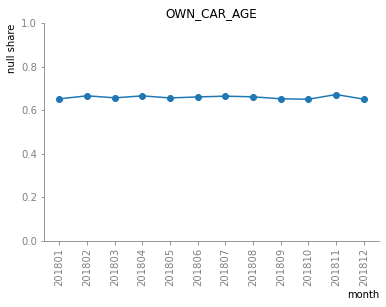

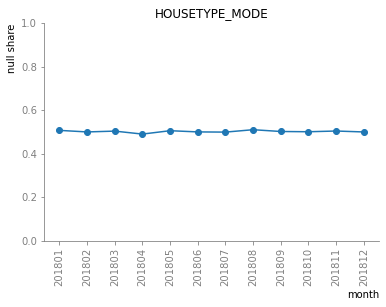

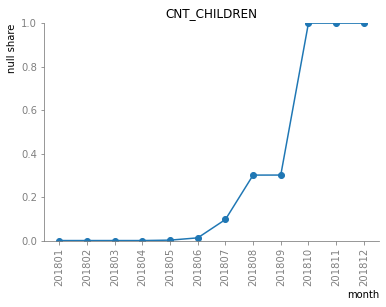

In [104]:
check_cols = [
    'OWN_CAR_AGE',
    'HOUSETYPE_MODE',
    'CNT_CHILDREN',    
]

for pred in check_cols:
    share_of_nulls(data, col_month, pred)

## Data Split
- splitting data into training sample, validation sample, test sample, out of time sample and historical out of time sample

### Without Stratification

In [105]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
data.loc[data[col_month] <= 201801, 'sample'] = 'hoot'
data.loc[data[col_month] >= 201811, 'sample'] = 'oot'

# define intime mask
intime_mask = (data[col_month] > 201801) & (data[col_month] < 201811)
# use train_test_split to split the intime into train and rest (don't forget seed)
data_train, data_rest = train_test_split(data[intime_mask], test_size=0.4, random_state = 12)
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed)
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12)
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

In [106]:
data['sample'].value_counts(dropna = False)

train    35829
oot      13475
test     11944
valid    11943
hoot      6809
Name: sample, dtype: int64

In [107]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, np.mean)
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 0.1])
    plt.ylabel('default rate', loc='top')
    plt.xlabel('month', loc='right')
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray') 
    
    plt.show()

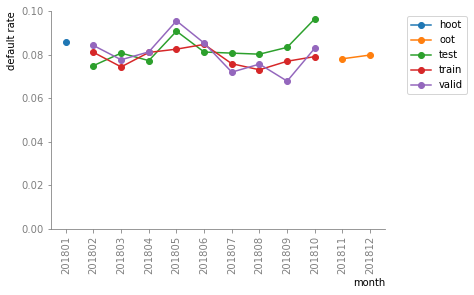

In [108]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

### With Stratification
- Stratification allows us to ensure that in each sample is approximately the same distribution in specified variables

In [109]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
data.loc[data[col_month] <= 201801, 'sample'] = 'hoot'
data.loc[data[col_month] >= 201811, 'sample'] = 'oot'

# define intime mask
intime_mask = (data[col_month] > 201801) & (data[col_month] < 201811)
# use train_test_split to split the intime into train and rest (don't forget seed); use stratification
data_train, data_rest = train_test_split(data[intime_mask], test_size=0.4, random_state = 12, stratify = (data[intime_mask][[col_month, col_target]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[[col_month, col_target]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

In [110]:
data['sample'].value_counts(dropna = False)

train    35829
oot      13475
test     11944
valid    11943
hoot      6809
Name: sample, dtype: int64

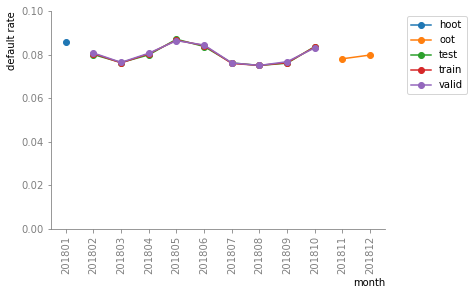

In [111]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

### Define sample masks

In [112]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid')
test_mask = (data['sample'] == 'test')
oot_mask = (data['sample'] == 'oot')
hoot_mask = (data['sample'] == 'hoot')

# Cross-Validation

We never want to evaluate performance on the training sample, but we use all of the observations for both training and validation. We will take a look at k-fold cross-validation.

<img src="https://miro.medium.com/max/700/1*AAwIlHM8TpAVe4l2FihNUQ.png" width=500px style="float: center"/>

In [113]:
kf = KFold(n_splits=5)
kf.get_n_splits(data)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [114]:
KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(data):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [16000 16001 16002 ... 79997 79998 79999] TEST: [    0     1     2 ... 15997 15998 15999]
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [16000 16001 16002 ... 31997 31998 31999]
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [32000 32001 32002 ... 47997 47998 47999]
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [48000 48001 48002 ... 63997 63998 63999]
TRAIN: [    0     1     2 ... 63997 63998 63999] TEST: [64000 64001 64002 ... 79997 79998 79999]


# More Data Cleaning

In [115]:
# find columns with infinity values
cols_with_inf = []
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

Column MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_DIV_MEAN_AMTCR_0M_INFM includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_DIV_MEAN_AMTCR_0M_12M includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_ACTIVE includes infinity values.


In [116]:
# replace infinity values
for col in cols_with_inf:
    data[col].replace(np.inf, 9999999, inplace = True)

# Grouping and WOE Transformation of Variables

## Automatic Grouping

In [117]:
# define bins for grouping numerical predictors
def get_grouping_numerical(dt, predictor, n_bins = 7):
    return np .unique([round(b, 4) for b in dt[predictor].quantile([i / n_bins for i in range(n_bins+1)])])

# define bins for grouping categorical predictors
def get_grouping_categorical(dt, predictor, n_bins = 7):
    categories_sorted_by_freq = dt[predictor].value_counts(sort = True, ascending = False)
    grouping = [[cat] for cat in categories_sorted_by_freq.index[0:n_bins-1]]
    if len(categories_sorted_by_freq) >= n_bins-1:
        grouping.append(list(categories_sorted_by_freq.index[n_bins-1:]))
        
    return grouping

In [118]:
predictor_grouping = {}
for col in tqdm(cols_pred_num):
    predictor_grouping[col] = get_grouping_numerical(data[train_mask], col)

for col in tqdm(cols_pred_cat):
    predictor_grouping[col] = get_grouping_categorical(data[train_mask], col)

Let us have:
- tot_good...total number of goods
- tot_bad...total number of bads
- grp_good... number of goods in a given group
- grp_bad...number of bads in a given group

Then weight of evidence for the given group is computed as:
$$ woe = log \left( \frac{\frac{grp\_bad}{grp\_good}}{\frac{tot\_bad}{tot\_good}} \right) $$


<span style="color:red">**TO DO:** define following functions</span>

- weight_of_evidence_numeric <br>
    - Parameters: <br>
        data ... data set<br>
        predictor ... name of the predictor to be processed<br>
        col_target ... name of target variable<br>
        borders ... list of values defining borders of the bins; left most and right most borders included<br>
            Example: [-np.inf, 1, np.inf]
    - Returns:
        Dictionary, where key is a tuple with two values (lower and upper bound of the bin) and value is weight of evidence for respective bin. In case of present 
        null values, additional item is included in returned dictionary - key = 'null', value = woe for null values<br>
            Example: {(-np.inf, 1): -0.25, (1, np.inf): 0.5, 'null': 0.12}
        
- weight_of_evidence_categ <br>
    - Parameters: <br>
        data ... data set<br>
        predictor ... name of the predictor to be processed<br>
        col_target ... name of target variable<br>
        categories ... list of lists, where inner lists represents values that belong to one category.<br>
            Example: [['MONDAY', 'TUESDAY', 'WEDNESDAY'], ['THURSDAY', 'FRIDAY'], ['SATURDAY', 'SUNDAY']]
    - Returns:
        Dictionary, where key is a string coressponding to given value of the predictor and value is woe for this predictor category. In case of present 
        null values, additional item is included in returned dictionary - key = 'null', value = woe for null values<br>
            Example: {'MONDAY': 0.25, 'TUESDAY': 0.25, 'WEDNESDAY': 0.25, 'THURSDAY': 0.02, 'FRIDAY': 0.02, 'SATURDAY': -0.3, 'SUNDAY': -0.3, 'null': 0.0}

In [134]:
from woe_functions import *

In [135]:
predictor_woe = {}
for col in tqdm(cols_pred_num):
    predictor_woe[col] = weight_of_evidence_numeric(data[train_mask], col, col_target, borders = predictor_grouping[col])

for col in tqdm(cols_pred_cat):
    predictor_woe[col] = weight_of_evidence_categ(data[train_mask], col, col_target, categories = predictor_grouping[col])

C:\Users\macou\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\macou\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\macou\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Apply grouping

In [ ]:
def apply_grouping_categorical(data_predictor, predictor_grouping):
    grouping = predictor_grouping.copy()
    
    # check for unknown values
    for val in data_predictor[data_predictor.notnull()].unique():
        if val not in grouping.keys():
            grouping[val] = 0
    
    if 'null' in grouping.keys():
        woe_null = grouping['null']
        del grouping['null']
    else:
        woe_null = 0
    
    woe_predictor = data_predictor.replace(grouping)
    woe_predictor.fillna(woe_null, inplace = True)
    
    return woe_predictor

def apply_grouping_numerical(data_predictor, predictor_grouping):
    grouping = predictor_grouping.copy()
    
    if 'null' in grouping.keys():
        woe_null = grouping['null']
        del grouping['null']
    else:
        woe_null = 0
    
    woe_data = sorted([(b[1], grouping[b]) for b in grouping.keys()], key = lambda x: x[0])
    borders = [-np.inf] + [b[0] for b in woe_data]
    woe = [b[1] for b in woe_data]
    woe_predictor = pd.cut(data_predictor, bins = borders, labels = woe, ordered = False).astype(float)
    woe_predictor.fillna(woe_null, inplace = True)
    
    return woe_predictor

In [ ]:
data_woe = data[[col_target, 'sample', col_month]].copy()

for pred in tqdm(cols_pred_num):
    data_woe[pred] = apply_grouping_numerical(data[pred], predictor_woe[pred])
    
for pred in tqdm(cols_pred_cat):
    data_woe[pred] = apply_grouping_categorical(data[pred], predictor_woe[pred])

## Check_grouping_stability

In [ ]:
def predictor_stability(dt, predictor, col_target, col_month):
    dt_grp = dt.groupby([col_month, predictor]).agg(
        obs_cnt = (col_target, len),
        default_rate = (col_target, np.mean)
    )
    dt_grp.reset_index(inplace = True)
    
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = predictor, values = 'default_rate')
    
    fig, axs = plt.subplots(1, 2, figsize = (12,4))
    fig.suptitle(predictor)
    for col in dt_grp_pivot.columns:
        axs[0].plot(range(len(dt_grp_pivot)), dt_grp_pivot[col], label = f'{col:.4f}')

    axs[0].set_xticks(range(len(dt_grp_pivot)))
    axs[0].set_xticklabels(dt_grp_pivot.index, rotation = 90)
    axs[0].set_xlabel('month', loc='right')
    axs[0].set_ylabel('default_rate', loc='top')
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray') 
    axs[0].legend(loc = 'best')
    
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = predictor, values = 'obs_cnt')
    dt_grp_pivot['tot_cnt'] = dt_grp_pivot.sum(axis = 1)
    
    for col in dt_grp_pivot.columns:
        dt_grp_pivot[col] /= dt_grp_pivot['tot_cnt']
    del dt_grp_pivot['tot_cnt']
    
    for col in dt_grp_pivot.columns:
        axs[1].plot(range(len(dt_grp_pivot)), dt_grp_pivot[col], label = f'{col:.4f}')

    axs[1].set_xticks(range(len(dt_grp_pivot)))
    axs[1].set_xticklabels(dt_grp_pivot.index, rotation = 90)
    axs[1].set_xlabel('month', loc='right')
    axs[1].set_ylabel('frequency', loc='top')
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray') 
    axs[1].legend(loc = 'best')
    
    plt.show()

In [ ]:
for pred in cols_pred[0:5]:
    predictor_stability(data_woe, pred, col_target, col_month)

# Logistic Regression

## No penalty

In [ ]:
# fit logistig regression with all predictors
logreg = LogisticRegression(
    penalty = 'none',
    max_iter = 2000
)

logreg.fit(data_woe[train_mask][cols_pred], data_woe[train_mask][col_target])

In [ ]:
# print predictor coefficients (sorted by magnitude)
preds_coef = []
for pred, coef in zip(cols_pred, logreg.coef_[0]):
    preds_coef += [(pred, coef)]
    
sorted(preds_coef, key = lambda x: abs(x[1]), reverse = True)[0:15]

In [ ]:
# predict probability
data_woe = data_woe.assign(prediction = logreg.predict_proba(data_woe[cols_pred])[:,1])

In [ ]:
# calculate gini for different samples
col_score = 'prediction'

gini_hoot  = 2 * roc_auc_score(data_woe[hoot_mask][col_target],  data_woe[hoot_mask] [col_score]) - 1
gini_train = 2 * roc_auc_score(data_woe[train_mask][col_target], data_woe[train_mask][col_score]) - 1
gini_valid = 2 * roc_auc_score(data_woe[valid_mask][col_target], data_woe[valid_mask][col_score]) - 1
gini_test  = 2 * roc_auc_score(data_woe[test_mask][col_target],  data_woe[test_mask] [col_score]) - 1
gini_oot   = 2 * roc_auc_score(data_woe[oot_mask][col_target],   data_woe[oot_mask]  [col_score]) - 1

print(f'hoot:    {gini_hoot:.4f}')
print(f'train:   {gini_train:.4f}')
print(f'valid:   {gini_valid:.4f}')
print(f'test:    {gini_test:.4f}')
print(f'oot:     {gini_oot:.4f}')

## Penalty

In [ ]:
coefs = []
consts = [0.0001, 0.001, 0.01, 0.1, 1.0]
models = []
for c in consts:
    # fit logistig regression with all predictors and penalty
    logreg = LogisticRegression(
        penalty = 'l1'
        , C = c
        , solver = 'liblinear'
        , max_iter = 2000
    )

    logreg.fit(data_woe[train_mask][cols_pred], data_woe[train_mask][col_target])
    models.append(logreg)
    coefs.append(logreg.coef_[0])

In [ ]:
coefs

In [ ]:
fig = plt.figure(figsize = (10,6))

ax = plt.gca()

ax.plot(consts, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('Regularization constant')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of regularization constant');

In [ ]:
# select the model you like (or better, the best performing model)
logreg = models[3]

In [ ]:
# predict probability
data_woe = data_woe.assign(prediction = logreg.predict_proba(data_woe[cols_pred])[:,1])

In [ ]:
# calculate gini for different samples
col_score = 'prediction'

gini_hoot  = 2 * roc_auc_score(data_woe[hoot_mask][col_target],  data_woe[hoot_mask] [col_score]) - 1
gini_train = 2 * roc_auc_score(data_woe[train_mask][col_target], data_woe[train_mask][col_score]) - 1
gini_valid = 2 * roc_auc_score(data_woe[valid_mask][col_target], data_woe[valid_mask][col_score]) - 1
gini_test  = 2 * roc_auc_score(data_woe[test_mask][col_target],  data_woe[test_mask] [col_score]) - 1
gini_oot   = 2 * roc_auc_score(data_woe[oot_mask][col_target],   data_woe[oot_mask]  [col_score]) - 1

print(f'hoot:    {gini_hoot:.4f}')
print(f'train:   {gini_train:.4f}')
print(f'valid:   {gini_valid:.4f}')
print(f'test:    {gini_test:.4f}')
print(f'oot:     {gini_oot:.4f}')

<span style="color:red">**TO DO:** Try using 'l2' and 'elasticnet' regularization with different setups, investigate the performace, which one would you select?</span>

In [ ]:
# select one of the model's prediction 
data_woe['prediction_final'] = data_woe['prediction']

# Performance Characteristics

## ROC curve

In [ ]:
data_woe = data_woe.assign(prediction_score = np.log(data_woe['prediction_final'] / (1 - data_woe['prediction_final'])))

In [ ]:
fpr_train, tpr_train, treshold_train = roc_curve(data_woe[train_mask][col_target], data_woe[train_mask]['prediction_score'])
fpr_valid, tpr_valid, treshold_valid = roc_curve(data_woe[valid_mask][col_target], data_woe[valid_mask]['prediction_score'])
fpr_test, tpr_test, treshold_test    = roc_curve(data_woe[test_mask][col_target], data_woe[test_mask]['prediction_score'])
fpr_oot, tpr_oot, treshold_oot       = roc_curve(data_woe[oot_mask][col_target], data_woe[oot_mask]['prediction_score'])
fpr_hoot, tpr_hoot, treshold_hoot    = roc_curve(data_woe[hoot_mask][col_target], data_woe[hoot_mask]['prediction_score'])

In [ ]:
fig = plt.figure(figsize = (6,6))
plt.plot(fpr_train, tpr_train, label = 'train')
plt.plot(fpr_valid, tpr_valid, label = 'valid')
plt.plot(fpr_test, tpr_test, label = 'test')
plt.plot(fpr_oot, tpr_oot, label = 'oot')
plt.plot(fpr_hoot, tpr_hoot, label = 'hoot')
plt.plot([0, 1], [0, 1], ls = '--', color = 'black')
plt.xlim([0,1])
plt.ylim([0,1])

ax = plt.gca()
ax.spines['right'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray') 
ax.legend(loc = 'best')

plt.xlabel('False positive rate', loc='right')
plt.ylabel('True positive rate', loc='top')
plt.title('Roceiver operating characteristic curve')

plt.legend(loc = 'lower right')
plt.show()

## Performance per Sample

In [ ]:
samples = data_woe['sample'].unique()
gini_sample = []
for sample in samples:
    mask = data_woe['sample'] == sample
    gini = 2 * roc_auc_score(data_woe[mask][col_target], data_woe[mask]['prediction_score']) - 1
    gini_sample += [(sample, gini)]
    
pd.DataFrame(gini_sample, columns = ['sample', 'gini']).set_index('sample')

## Gini in Time

In [ ]:
months = sorted(data[col_month].unique())
gini_in_time = pd.DataFrame(index = months)
for sample in data['sample'].unique():
    dt = data_woe[data_woe['sample'] == sample]
    months_sample = dt[col_month].unique()
    gini_sample_month = []
    for m in months_sample:
        mask = dt[col_month] == m
        gini = 2 * roc_auc_score(dt[mask][col_target], dt[mask]['prediction_score']) - 1
        gini_sample_month += [(m, gini)]
    gini_sample_month = pd.DataFrame(gini_sample_month, columns = [col_month, sample]).set_index(col_month)
    gini_in_time = gini_in_time.join(gini_sample_month, how = 'left')
gini_in_time

In [ ]:
fig = plt.figure(figsize=(7,5))

for sample in samples:
    plt.plot(range(len(gini_in_time)), gini_in_time[sample], label = sample, marker = 'o')

plt.legend(loc = 'best')
plt.xticks(range(len(gini_in_time)), gini_in_time.index, rotation = 45)
plt.ylim([0,0.6])
plt.ylabel('Gini', loc='top')
plt.xlabel('month', loc='right')
plt.title('Gini in time')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray') 
ax.legend(loc = 'best')

plt.show()

# Score Distribution

In [ ]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt['score_bin'] = pd.cut(dt[col_score], bins = bins, include_lowest = True)
    
    dt_grp = dt.groupby('score_bin').agg(
        bad_cnt = (col_target, sum),
        tot_cnt = (col_target, len),
        def_rt = (col_target, np.mean),
        avg_score = (col_score, np.mean)
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count', loc='top')
    axs[0].set_xlabel('score', loc='right')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray') 
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red', loc='top')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray') 
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'].fillna(0), color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency',loc='top')
    axs[1].set_xlabel('score', loc='right')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')
    
    return dt_grp

In [ ]:
dt_grp = plot_score_calibration(data_woe, 'prediction_score', col_target)